# Load packages

In [86]:
# Basics
import numpy as np
import pandas as pd
import itertools

# Viz
import matplotlib.pylab as plt

%matplotlib inline 


# Image related
from cv2 import resize, imread 

# Viz

# ML
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedGroupKFold, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, log_loss, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## DL
import keras
from keras import backend as k
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from scikeras.wrappers import KerasClassifier

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

In [87]:
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

# Load data files

In [88]:
X = np.load("../Data/X.npy")
y = np.load("../Data/Y.npy")

# Exploratory Data Analysis

## Basic information

In [89]:
def describeData(a, b):
    print(f"Total number of images: {len(a)}")
    print(f"Number of IDC(-) images: {np.sum(b==0)}")
    print(f"Number of IDC(+) images: {np.sum(b)}")
    print(f"Percentage of positive images: {100*np.mean(b):.2f}%")
    print(f"Image shape (Width, Height, Channels): {a[0].shape}")


In [90]:
describeData(X, y)

Total number of images: 5547
Number of IDC(-) images: 2759
Number of IDC(+) images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


## Visualize the images

In [91]:
imgs0 = X[y==0]
imgs1 = X[y==1]

In [92]:
def plotSamples(a, b):
    """
    Plot a bunch of numpy arrays sorted by label
    """

    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1, 6, col+1)
            plt.title("IDC (-)")
            plt.imshow(a[row+col])
            plt.axis('off')

            plt.subplot(1, 6, col+4)
            plt.title("IDC (+)")
            plt.imshow(b[row+col])
            plt.axis('off')


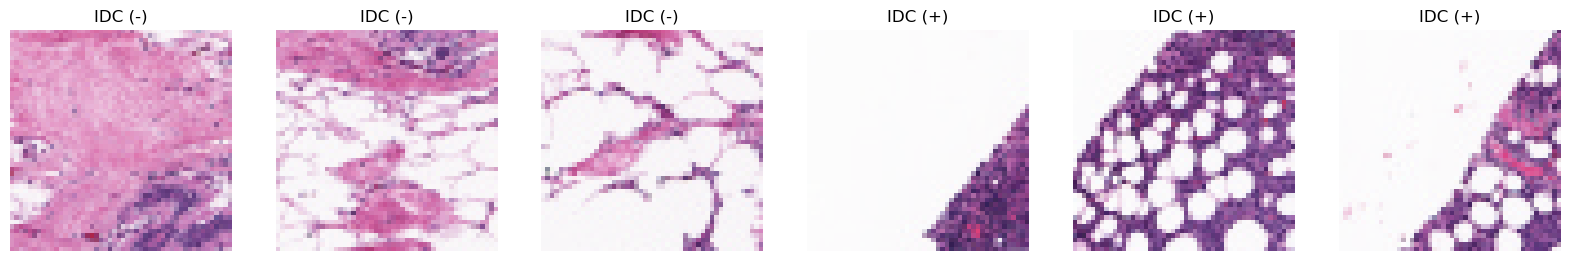

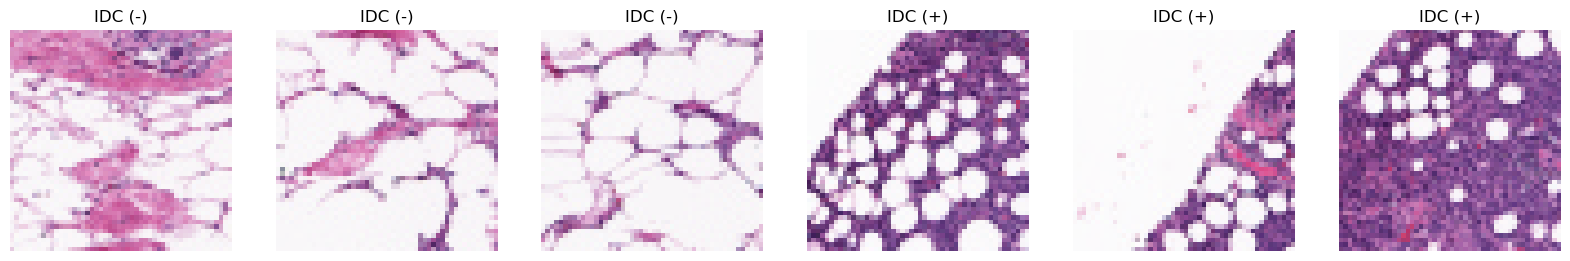

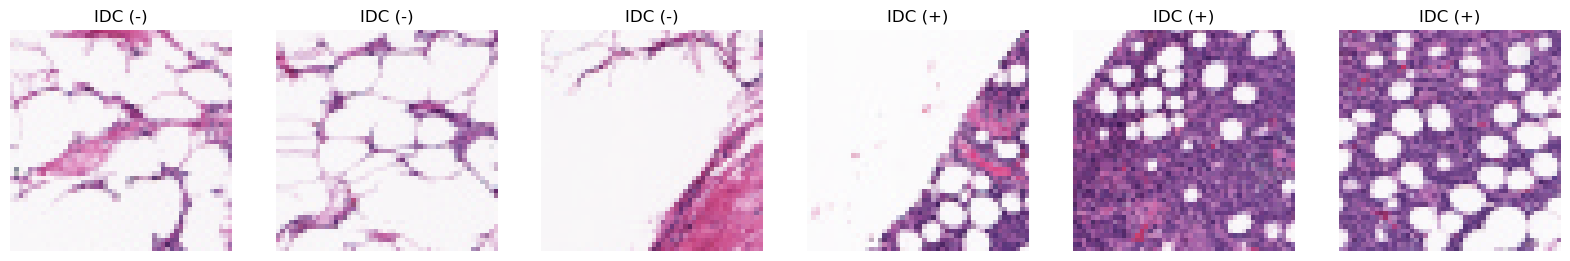

In [93]:
plotSamples(imgs0, imgs1)

In [94]:
def plotHistogram(a, index_):
    """
    Plot histogram of RGB Pixel Intensities
    """

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(a[index_])
    plt.axis('off')
    plt.title('IDC (+)' if y[index_] else 'IDC (-)')

    histo = plt.subplot(1, 2, 2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30

    # lw: linewidth
    plt.hist(a[index_, :, :, 0].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
    plt.hist(a[index_, :, :, 1].flatten(), bins=n_bins, lw=0, color='r', alpha=0.5)
    plt.hist(a[index_, :, :, 2].flatten(), bins=n_bins, lw=0, color='b', alpha=0.5)



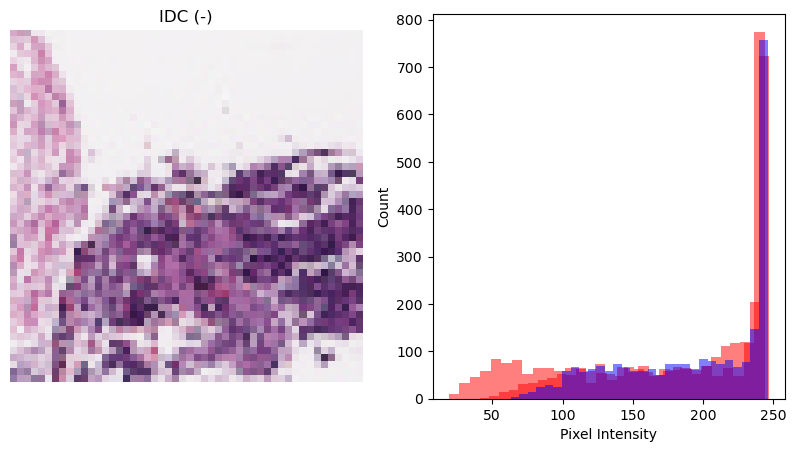

In [95]:
plotHistogram(X, 100)

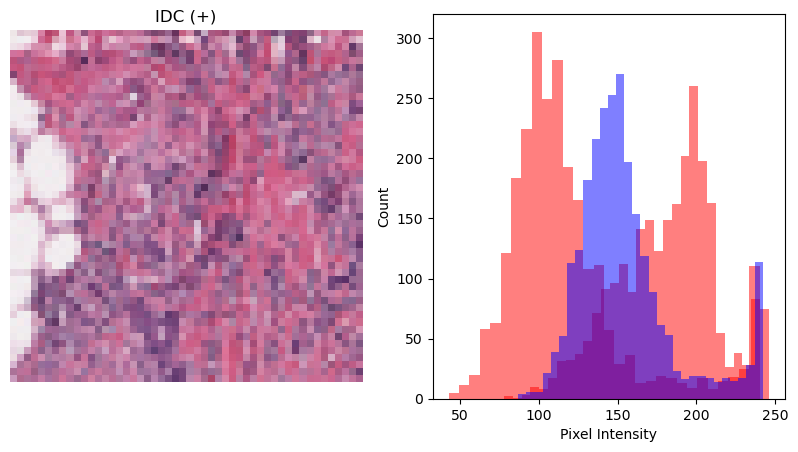

In [96]:
plotHistogram(X, 5000)

# Data preprocessing

## Scale
The data is scaled from 0 to 256. To make the data compatible with a wide variety of different classification algorithms, the data will be scaled from 0 to 1.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2023)

In [98]:
X_train.shape

(4992, 50, 50, 3)

In [99]:
X_test.shape

(555, 50, 50, 3)

In [100]:
# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
y_train = y_train[0:30000]
X_test = X_test[0:30000] 
y_test = y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)

Training Data Shape: (4992, 50, 50, 3) (4992, 50, 50, 3)
Testing Data Shape: (555, 50, 50, 3) (555, 50, 50, 3)


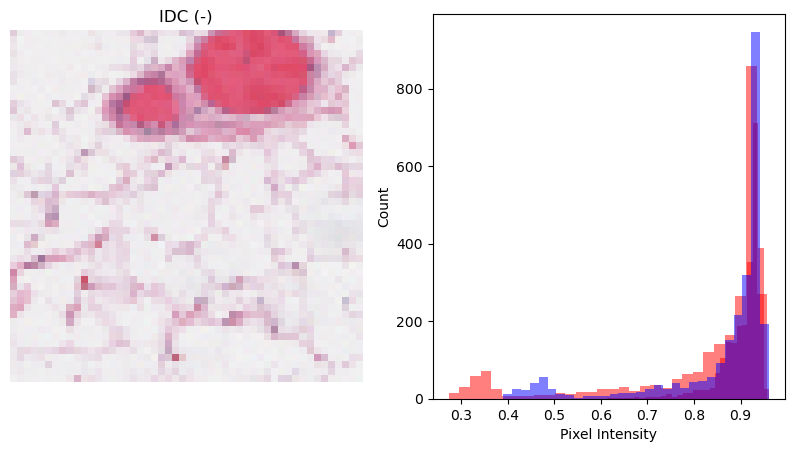

In [101]:
plotHistogram(X_train, 50)

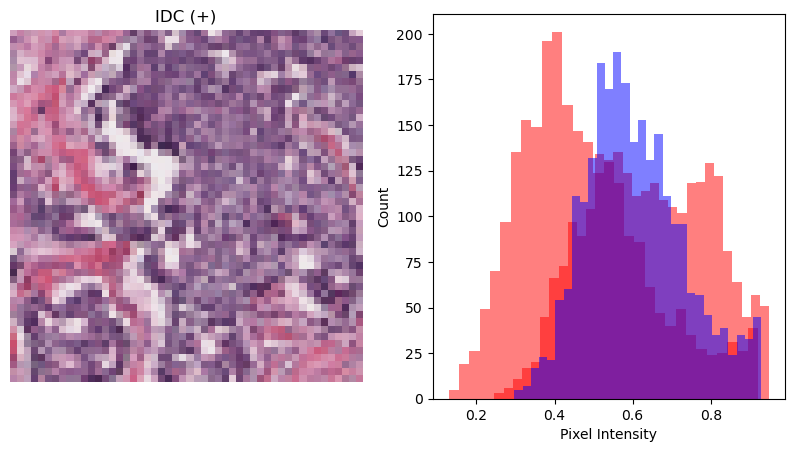

In [102]:
plotHistogram(X_train, 3499)

# Modeling

## Neural Network - CNN

### One-hot encode labels

In [103]:
y_train_2 = to_categorical(y_train, num_classes=2)
y_test_2 = to_categorical(y_test, num_classes=2)

### Contruct the CNN models

1. no dropout, no augmentation
2. add augmentation, still has overfit
3. add dropout not overfit
4. tune hyperparater
5. read latest article, write a summary
6. upload to github

In [104]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]

In [105]:
model = Sequential()

model.add(Conv2D(36, kernel_size=3, activation='relu', input_shape=(img_rows, img_cols, 3), padding='same'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Conv2D(36, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(2))

model.add(Conv2D(36, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(576, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam'
            , loss='categorical_crossentropy'
            , metrics=['accuracy'])

In [106]:
datagen = ImageDataGenerator(
        featurewise_center=False  # set input mean to 0 over the dataset
        , samplewise_center=False  # set each sample mean to 0
        , featurewise_std_normalization=False  # divide inputs by std of the dataset
        , samplewise_std_normalization=False  # divide each input by its std
        , zca_whitening=False  # apply ZCA whitening
        , rotation_range=10  # randomly rotate images in the range (degrees, 0 to 180)
        , width_shift_range=0.1  # randomly shift images horizontally (fraction of total width)
        , height_shift_range=0.1  # randomly shift images vertically (fraction of total height)
        , horizontal_flip=True  # randomly flip images
        , vertical_flip=False
        )



In [107]:
datagen.fit(X_train)

In [108]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=30)
mc = ModelCheckpoint('best_model.h5'
                    , monitor='val_accuracy'
                    , mode='max'
                    , verbose=1
                    , save_best_only=True)

In [109]:
training = model.fit_generator(datagen.flow(X_train, y_train_2, batch_size=32)
                             , steps_per_epoch=len(X_train)//32
                             , epochs=100
                             , validation_data=[X_test, y_test_2]
                             , callbacks=[es, mc])




Epoch 1/100
156/156 [==============================] - ETA: 0s - loss: 0.6068 - accuracy: 0.6645
Epoch 00001: val_accuracy improved from -inf to 0.71171, saving model to best_model.h5
156/156 [==============================] - 12s 71ms/step - loss: 0.6068 - accuracy: 0.6645 - val_loss: 0.5685 - val_accuracy: 0.7117
Epoch 2/100
156/156 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.7266
Epoch 00002: val_accuracy improved from 0.71171 to 0.75315, saving model to best_model.h5
156/156 [==============================] - 11s 71ms/step - loss: 0.5566 - accuracy: 0.7266 - val_loss: 0.5338 - val_accuracy: 0.7532
Epoch 3/100
156/156 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7462
Epoch 00003: val_accuracy improved from 0.75315 to 0.76577, saving model to best_model.h5
156/156 [==============================] - 11s 73ms/step - loss: 0.5387 - accuracy: 0.7462 - val_loss: 0.5100 - val_accuracy: 0.7658
Epoch 4/100
156/156 [======================

In [115]:
model.evaluate(X_test, y_test_2)

18/18 [==============================] - 0s 13ms/step - loss: 0.4531 - accuracy: 0.8036


[0.4531475007534027, 0.8036035895347595]

In [116]:
best_model = load_model('best_model.h5')

In [117]:
best_model.evaluate(X_test, y_test_2)

18/18 [==============================] - 0s 11ms/step - loss: 0.4121 - accuracy: 0.8288


[0.41214028000831604, 0.8288288116455078]

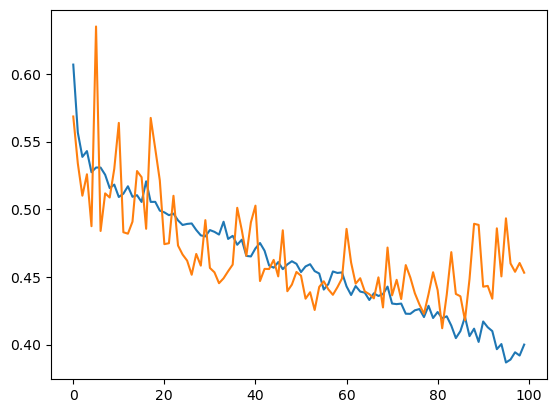

In [118]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
#plt.ylim(ymin=0.6, ymax = 1.1)
plt.show()

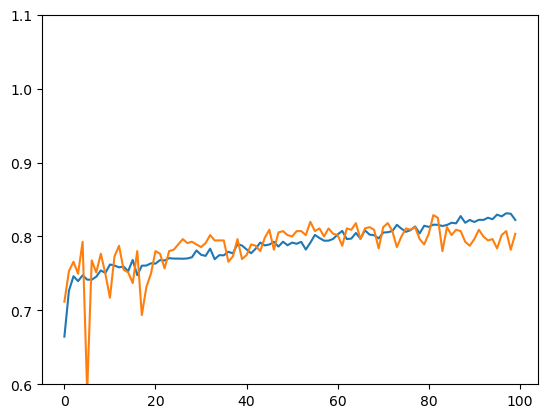

In [119]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.ylim(ymin=0.6, ymax = 1.1)
plt.show()

# Neural Network - CNN: Hyperparameter tuning

In [83]:
def cnn_cl_bo(neurons, activation, optimizer, learning_rate
           , batch_size, epochs, cnn_layers, kernel_size, maxpool, maxpool_size
           #, normalization
           , dropout, dropout_rate):
    optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
    optimizerD = {'Adam': Adam(learning_rate=learning_rate)
                , 'SGD': SGD(learning_rate=learning_rate)
                , 'RMSprop': RMSprop(learning_rate=learning_rate)
                , 'Adadelta': Adadelta(learning_rate=learning_rate)
                , 'Adagrad': Adagrad(learning_rate=learning_rate)
                , 'Adamax': Adamax(learning_rate=learning_rate)
                , 'Nadam': Nadam(learning_rate=learning_rate)
                , 'Ftrl': Ftrl(learning_rate=learning_rate)} 
    
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU, 'relu']
    
    neurons = round(neurons)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    cnn_layers = round(cnn_layers)
    kernel_size = round(kernel_size)
    maxpool_size = round(maxpool_size)

    def cnn_cl_func ():
       cnn = Sequential()

       # Add the first CNN layer
       cnn.add(Conv2D(neurons, kernel_size=kernel_size, activation=activation
                       , input_shape=(img_rows, img_cols, 3), padding='same'))
       cnn.add(MaxPool2D(maxpool_size))
       cnn.add(Dropout(dropout_rate))
        
       for i in range(cnn_layers):
              cnn.add(Conv2D(neurons, kernel_size=kernel_size, activation=activation
                     , padding='same'))
             
              if maxpool > 0.5:
                    cnn.add(MaxPool2D(maxpool_size))

              if dropout > 0.5:
                   cnn.add(Dropout(dropout_rate))

       cnn.add(Flatten())
       cnn.add(Dense(576, activation=activation))
       cnn.add(Dropout(dropout_rate))
       cnn.add(Dense(1, activation='sigmoid'))

       cnn.compile(optimizer=optimizer
                   , loss='binary_crossentropy'
                   , metrics=['accuracy'])
       
       return cnn
    
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    cnn = KerasClassifier(build_fn=cnn_cl_func, epochs=epochs, batch_size=batch_size,
                         verbose=0)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(cnn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score
       


# Set parameters

In [84]:
params_cnn ={'neurons': (10, 100)
           , 'activation':(0, 9)
           , 'optimizer':(0, 7)
           , 'learning_rate':(0.01, 1)
           , 'batch_size':(20, 100)
           , 'epochs':(50, 150)
           , 'cnn_layers':(1, 3)
           , 'kernel_size': (2, 4)
          #, 'normalization':(0, 1)
           , 'maxpool': (0, 1)
           , 'maxpool_size': (2, 4)
           , 'dropout':(0, 1)
           , 'dropout_rate':(0, 0.3)
}

In [85]:
cnn_bo = BayesianOptimization(cnn_cl_bo, params_cnn, random_state=2023)
cnn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... | cnn_la... |  dropout  | dropou... |  epochs   | kernel... | learni... |  maxpool  | maxpoo... |  neurons  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 